### Problem Statement
New buyers of residential properties are usually unfamiliar with the market prices. Depending on criterias such as locations, amenities, lot size and livable area, the price can varies greatly. As a data scientist, you would like to help buyers to determine the reasonable selling price for residential properties so that they are not over-paying for them and know when a property is a good deal.
Your tasks are:-
- Create a model to predict the sale price based on the features provided in the Ames Housing Dataset
- Identify the top 5 features which would greatly influence the price which the buyers should take note of

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

### Import Data

In [2]:
# Read train.csv
null_values = ['','#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
               '1.#QNAN', '<NA>', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null']
data = pd.read_csv('../datasets/train.csv', keep_default_na=False, na_values=null_values)

In [3]:
for feature in data.columns:
    print(f'{feature}: {data[feature].unique()}')

Id: [109 544 153 ... 916 639  10]
PID: [533352170 531379050 535304180 ... 909253010 535179160 527162130]
MS SubClass: [ 60  20  50 180 160  70 120 190  85  30  90  80  75  45  40 150]
MS Zoning: ['RL' 'RM' 'FV' 'C (all)' 'A (agr)' 'RH' 'I (all)']
Lot Frontage: [ nan  43.  68.  73.  82. 137.  35.  70.  21.  64. 120.  24.  74.  93.
  34.  80.  71.  72. 109.  40. 103. 100.  92.  65.  75.  60.  30.  79.
  41. 105. 107.  81.  36.  63.  32.  94.  44.  50.  48.  67.  88.  83.
  53.  58.  57.  52.  87. 134.  56.  54. 140.  78.  85.  90.  96.  62.
  49.  59. 155.  91.  61.  86. 128.  77.  42.  89.  51.  69.  55. 112.
  76. 125.  98. 113. 102.  22. 122.  84. 119. 118.  66.  95. 108. 195.
 106.  39. 110. 130.  97.  45.  37. 123.  38. 129. 115.  47. 114. 104.
  46. 121. 124. 313. 141. 101.  99. 160. 174.  26. 144. 138. 111.  25.
  33. 200. 150. 117. 153. 116. 135.]
Lot Area: [13517 11492  7922 ... 12444 11449  7558]
Street: ['Pave' 'Grvl']
Alley: ['NA' 'Pave' 'Grvl']
Lot Shape: ['IR1' 'Reg' 'IR2' 

In [4]:
# Determing the shape of the training dataset
data.shape

(2051, 81)

In [5]:
data.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,138500


### Clean Data

#### Checking for missing data

In [6]:
# Calculating the percentage of rows with missing data for each features
temp = data.isnull().sum()
for i in range(len(temp)):
    print(temp.index[i], ': ',  temp[i], ', Percentage of All Rows', ": ", 
          temp[i]/data.shape[0], ', Data Type: ', data.dtypes[i])

Id :  0 , Percentage of All Rows :  0.0 , Data Type:  int64
PID :  0 , Percentage of All Rows :  0.0 , Data Type:  int64
MS SubClass :  0 , Percentage of All Rows :  0.0 , Data Type:  int64
MS Zoning :  0 , Percentage of All Rows :  0.0 , Data Type:  object
Lot Frontage :  330 , Percentage of All Rows :  0.16089712335446124 , Data Type:  float64
Lot Area :  0 , Percentage of All Rows :  0.0 , Data Type:  int64
Street :  0 , Percentage of All Rows :  0.0 , Data Type:  object
Alley :  0 , Percentage of All Rows :  0.0 , Data Type:  object
Lot Shape :  0 , Percentage of All Rows :  0.0 , Data Type:  object
Land Contour :  0 , Percentage of All Rows :  0.0 , Data Type:  object
Utilities :  0 , Percentage of All Rows :  0.0 , Data Type:  object
Lot Config :  0 , Percentage of All Rows :  0.0 , Data Type:  object
Land Slope :  0 , Percentage of All Rows :  0.0 , Data Type:  object
Neighborhood :  0 , Percentage of All Rows :  0.0 , Data Type:  object
Condition 1 :  0 , Percentage of All Rows

- A few features have missing data with Lot Frontage and Garage Yr Blt having more than 5% of rows data missing

#### Garage Area and Garage Cars Missing Data

In [7]:
# Check Garage Area and Garage Cars
data[data['Garage Area'].isnull()][['Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Area', 'Garage Cars', 'Garage Qual', 'Garage Cond']]

,Garage Type,Garage Yr Blt,Garage Finish,Garage Area,Garage Cars,Garage Qual,Garage Cond
1712,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


- Drop row since there is a garage (garage type is not NA) but other garage related information is missing.

#### Garage Year Built Missing Data

In [8]:
# Checking if Garage Yr Blt is NaN due to no Garage was built
data[(data['Garage Yr Blt'].isnull()) & (data['Garage Type']=='NA')][['Garage Yr Blt', 'Garage Qual', 'Garage Cond', 'Garage Finish', 'Garage Area', 'Garage Type']].head()

,Garage Yr Blt,Garage Qual,Garage Cond,Garage Finish,Garage Area,Garage Type
28,NaN,NA,NA,NA,0.0,NA
53,NaN,NA,NA,NA,0.0,NA
65,NaN,NA,NA,NA,0.0,NA
79,NaN,NA,NA,NA,0.0,NA
101,NaN,NA,NA,NA,0.0,NA


- Garage Yr Blt is NaN due to no garage was built
- Decide to set Garage Yr Blt as there are other garage features that can allow model to decide the impact of garage on SalePrice

Text(0.5, 1.0, 'Histogram Showing Majority of Garage Built in Same Year as House')

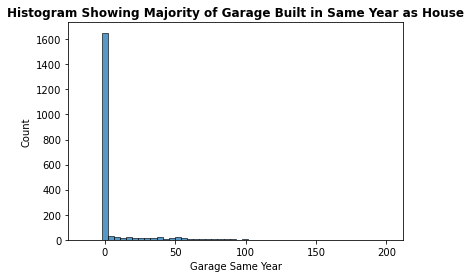

In [9]:
# Checking how many garages are built in same year as house
temp = data[['Year Built', 'Year Remod/Add', 'Garage Yr Blt']].copy()
temp['Garage Same Year'] = temp['Garage Yr Blt'] - temp['Year Built']
sns.histplot(temp['Garage Same Year'], bins = 50)
plt.title('Histogram Showing Majority of Garage Built in Same Year as House', fontweight='bold')

- Most garages are built in the same year as the house

Text(0.5, 1.0, 'Histogram of Garage Yr Blt With/Without Imputed Data')

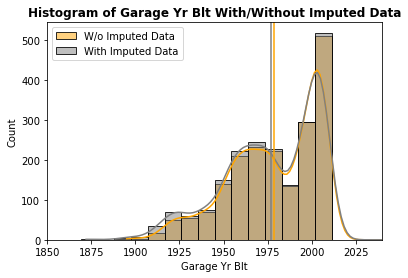

In [10]:
# To check Garage Yr Blt with imputed data vs without imputed data
sns.histplot(temp['Garage Yr Blt'], bins = 20, label='W/o Imputed Data', kde=True, color='orange', binrange=(1850, 2040))
sns.histplot(temp['Garage Yr Blt'].fillna(value=temp['Year Built']), bins = 20, label='With Imputed Data', kde=True, color='grey', binrange=(1850, 2040))
plt.axvline(x=temp['Garage Yr Blt'].mean(), color='orange')
plt.axvline(temp['Garage Yr Blt'].fillna(value=temp['Year Built']).mean(), color='grey')
plt.xlim(1850, 2040)
plt.legend()
plt.title('Histogram of Garage Yr Blt With/Without Imputed Data', fontweight='bold')

- Histogram did not change significantly by imputing Garage Yr Blt with Year Built data
- Slight shift to the left for average 'Garage Yr Blt' (~2 years)

In [11]:
# New Column for 'Garage Yr Blt and Impute missing 'Garage Yr Blt' rows with 'Year Built' data
data['Garage Yr Blt_Imputed'] = data['Garage Yr Blt'].fillna(value=data['Year Built'])

#### Lot Frontage Missing Data

Text(0.5, 1.0, 'Plot of Lot Frontage vs Lot Area')

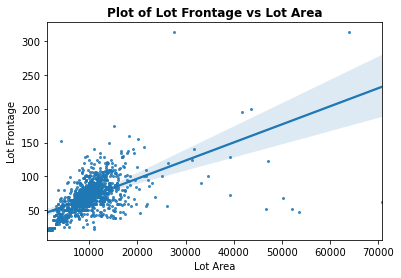

In [12]:
# Regplot of Lot Frontage and Lot Area
sns.regplot(x='Lot Area', y='Lot Frontage', data=data, scatter_kws={'s':4})
plt.title('Plot of Lot Frontage vs Lot Area', fontweight='bold')

Text(0.5, 1.0, 'Histogram of Lot Area (Lot Area < 300000)')

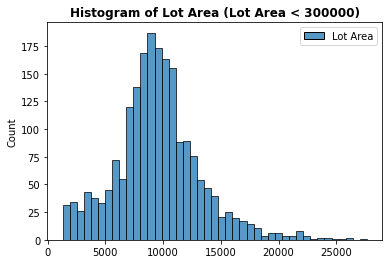

In [13]:
# Hisotgram of Lot Area (Lot Area < 300000)
sns.histplot(data[data['Lot Area'] < 30000][['Lot Area']])
plt.title('Histogram of Lot Area (Lot Area < 300000)', fontweight='bold')

Text(0.5, 1.0, 'Plot of Lot Frontage vs Lot Area (Lot Area < 300000)')

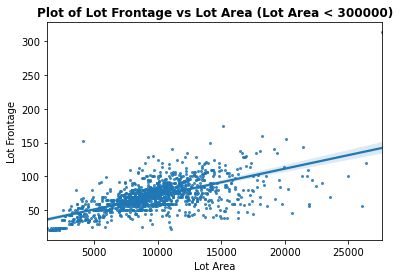

In [14]:
# Regplot of Lot Frontage and Lot Area (Lot Area < 300000)
sns.regplot(x='Lot Area', y='Lot Frontage', data=data[data['Lot Area']<30000], scatter_kws={'s':4})
plt.title('Plot of Lot Frontage vs Lot Area (Lot Area < 300000)', fontweight='bold')

- As the Lot Frontage and Lot Area seems quite linear, to impute the missing data with prediction from linear regression model of Lot Area and Lot Frontage with Lot Area based on 'Lot Area

In [15]:
# To impute missing Lot Frontage rows whereby Lot Area is less than 30000
temp = data[data['Lot Area'] < 30000][['Lot Area', 'Lot Frontage']]
temp.dropna(inplace=True)

# Train Test Split Data Set
x_train, x_test, y_train, y_test = train_test_split(temp[['Lot Area']], temp['Lot Frontage'], train_size = 0.8, random_state=60)

# Instantiate OLS Model
lr = LinearRegression()
lr.fit(x_train, y_train)
print(f'Train Score: {lr.score(x_train, y_train)}')
print(f'Test Score: {lr.score(x_test, y_test)}')

Train Score: 0.4342281123942917
Test Score: 0.4000025650215375


In [16]:
# Get index for missing Lot Frontage data for Lot Area < 30000
missing_index = data[(data['Lot Area'] < 30000) & (data['Lot Frontage'].isnull())]['Lot Frontage'].index

In [17]:
# Imputing data and save into Lot Frontage_Imputed
data['Lot Frontage_Imputed'] = data['Lot Frontage']
for i in missing_index:
    data.loc[i, 'Lot Frontage_Imputed'] = lr.predict([[data.loc[i, 'Lot Area']]])

Text(0.5, 1.0, 'Histogram of Lot Frontage Before/After Imputation')

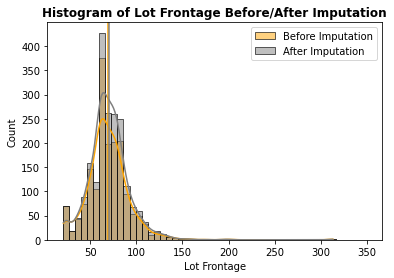

In [18]:
# Check Distribution
sns.histplot(data['Lot Frontage'], label='Before Imputation', color = 'orange', binrange=(20, 350), bins = 50, kde= True)
sns.histplot(data['Lot Frontage_Imputed'], label='After Imputation', color='grey', binrange=(20, 350), bins = 50, kde=True)
plt.axvline(data['Lot Frontage'].mean(), color='orange')
plt.axvline(data['Lot Frontage_Imputed'].mean(), color='grey')
plt.legend()
plt.title('Histogram of Lot Frontage Before/After Imputation', fontweight='bold')

- Distribution looks similar except for taller peak after imputing data
- Mean between original and Imputed is very similar

#### Remaining Missing Data

- As the remaining features missing data accoutns for less than 5%, to drop remaining missing data rows

#### Dropping Lot Frontage and Garage Yr Blt Columns and Dropping NA Rows

In [19]:
# Dropping Lot Frontage and Garage Yr Blt
data.drop(columns = ['Lot Frontage', 'Garage Yr Blt'], inplace=True)

# Dropping NA rows
data.dropna(inplace=True)

In [20]:
# % of data remaining
data.shape[0]/2051

0.9814724524622136

#### Recheck Missing Data Percentage

In [21]:
# Checking status of missing data for each feature
temp = data.isnull().sum()
for i in range(len(temp)):
    print(temp.index[i], ': ',  temp[i], ', Percentage of All Rows', ": ", 
          temp[i]/data.shape[0], ', Type: ', data.dtypes[i])

Id :  0 , Percentage of All Rows :  0.0 , Type:  int64
PID :  0 , Percentage of All Rows :  0.0 , Type:  int64
MS SubClass :  0 , Percentage of All Rows :  0.0 , Type:  int64
MS Zoning :  0 , Percentage of All Rows :  0.0 , Type:  object
Lot Area :  0 , Percentage of All Rows :  0.0 , Type:  int64
Street :  0 , Percentage of All Rows :  0.0 , Type:  object
Alley :  0 , Percentage of All Rows :  0.0 , Type:  object
Lot Shape :  0 , Percentage of All Rows :  0.0 , Type:  object
Land Contour :  0 , Percentage of All Rows :  0.0 , Type:  object
Utilities :  0 , Percentage of All Rows :  0.0 , Type:  object
Lot Config :  0 , Percentage of All Rows :  0.0 , Type:  object
Land Slope :  0 , Percentage of All Rows :  0.0 , Type:  object
Neighborhood :  0 , Percentage of All Rows :  0.0 , Type:  object
Condition 1 :  0 , Percentage of All Rows :  0.0 , Type:  object
Condition 2 :  0 , Percentage of All Rows :  0.0 , Type:  object
Bldg Type :  0 , Percentage of All Rows :  0.0 , Type:  object
Hou

- No missing data remaining

#### Checking for abnormal data

In [22]:
# Checking for abnormalities in Min and Max Values for first 40 features
data.iloc[:, 0:40].describe()

,Id,PID,MS SubClass,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF
count,2013.000000,2.013000e+03,2013.000000,2013.000000,2013.000000,2013.000000,2013.00000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000
mean,1471.711376,7.142358e+08,57.215599,9779.872827,6.101838,5.569300,1971.39692,1983.975161,99.204670,440.556880,48.289121,565.300050,1054.146051
std,845.118285,1.886782e+08,42.915426,4854.804303,1.426134,1.109238,30.18704,21.027091,174.254863,460.201357,165.901022,443.666714,446.587634
min,1.000000,5.263011e+08,20.000000,1300.000000,1.000000,1.000000,1872.00000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,751.000000,5.284771e+08,20.000000,7500.000000,5.000000,5.000000,1953.00000,1964.000000,0.000000,0.000000,0.000000,220.000000,792.000000
50%,1479.000000,5.354541e+08,50.000000,9375.000000,6.000000,5.000000,1974.00000,1993.000000,0.000000,368.000000,0.000000,473.000000,992.000000
75%,2195.000000,9.071800e+08,70.000000,11449.000000,7.000000,6.000000,2000.00000,2004.000000,160.000000,732.000000,0.000000,810.000000,1312.000000
max,2930.000000,9.241520e+08,190.000000,70761.000000,10.000000,9.000000,2010.00000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000


- No abnormalities

In [23]:
# Checking for abnormalities in Min and Max Values for next 20 features
data.iloc[:, 41:60].describe()

,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces
count,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000
mean,1160.635867,329.068554,5.616990,1495.321411,0.426230,0.064083,1.570790,0.368107,2.845007,1.043219,6.433681,0.583706
std,391.342859,425.515953,51.543202,500.031314,0.522978,0.252948,0.546615,0.499618,0.826873,0.210604,1.561909,0.634161
min,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,879.000000,0.000000,0.000000,1125.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000
50%,1092.000000,0.000000,0.000000,1440.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000
75%,1392.000000,689.000000,0.000000,1728.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000
max,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000


- No abnormalities

In [24]:
# Checking for abnormalities in Min and Max Values for next 20 features
data.iloc[:, 60:82].describe()

,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,Garage Yr Blt_Imputed,Lot Frontage_Imputed
count,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000
mean,1.769995,471.698460,93.993542,46.909091,22.579732,2.640338,16.754595,2.443120,52.299553,6.213612,2007.780427,180607.230502,1976.364630,69.751320
std,0.765336,215.396428,128.762567,65.979025,59.823932,25.464215,57.806245,38.136244,578.654347,2.744065,1.314574,79181.731295,26.614399,22.439979
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000,1872.000000,21.000000
25%,1.000000,315.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000,1959.000000,60.000000
50%,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160500.000000,1978.000000,69.070295
75%,2.000000,576.000000,168.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213000.000000,2001.000000,80.000000
max,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000,2010.000000,313.000000


- No abnormalities

#### Checking data types

In [25]:
# Checking data types of each colunms
data.dtypes[0:20]

Id               int64
PID              int64
MS SubClass      int64
MS Zoning       object
Lot Area         int64
Street          object
Alley           object
Lot Shape       object
Land Contour    object
Utilities       object
Lot Config      object
Land Slope      object
Neighborhood    object
Condition 1     object
Condition 2     object
Bldg Type       object
House Style     object
Overall Qual     int64
Overall Cond     int64
Year Built       int64
dtype: object

In [26]:
data.dtypes[20:40]

Year Remod/Add      int64
Roof Style         object
Roof Matl          object
Exterior 1st       object
Exterior 2nd       object
Mas Vnr Type       object
Mas Vnr Area      float64
Exter Qual         object
Exter Cond         object
Foundation         object
Bsmt Qual          object
Bsmt Cond          object
Bsmt Exposure      object
BsmtFin Type 1     object
BsmtFin SF 1      float64
BsmtFin Type 2     object
BsmtFin SF 2      float64
Bsmt Unf SF       float64
Total Bsmt SF     float64
Heating            object
dtype: object

In [27]:
data.dtypes[40:60]

Heating QC          object
Central Air         object
Electrical          object
1st Flr SF           int64
2nd Flr SF           int64
Low Qual Fin SF      int64
Gr Liv Area          int64
Bsmt Full Bath     float64
Bsmt Half Bath     float64
Full Bath            int64
Half Bath            int64
Bedroom AbvGr        int64
Kitchen AbvGr        int64
Kitchen Qual        object
TotRms AbvGrd        int64
Functional          object
Fireplaces           int64
Fireplace Qu        object
Garage Type         object
Garage Finish       object
dtype: object

In [28]:
data.dtypes[60:79]

Garage Cars       float64
Garage Area       float64
Garage Qual        object
Garage Cond        object
Paved Drive        object
Wood Deck SF        int64
Open Porch SF       int64
Enclosed Porch      int64
3Ssn Porch          int64
Screen Porch        int64
Pool Area           int64
Pool QC            object
Fence              object
Misc Feature       object
Misc Val            int64
Mo Sold             int64
Yr Sold             int64
Sale Type          object
SalePrice           int64
dtype: object

In [29]:
# Converting MS SubClass, PID to string as it is categorical data
# Converting Overall Qual, Overall Cond to string as it is ordinal data
for feature in ['MS SubClass', 'PID', 'Overall Qual', 'Overall Cond']:
    data[feature] = data[feature].astype('str')

#### Checking if 2nd Floor SF is 0 for 1Story House

Text(0.5, 1.0, '2nd Floor Area by House Style')

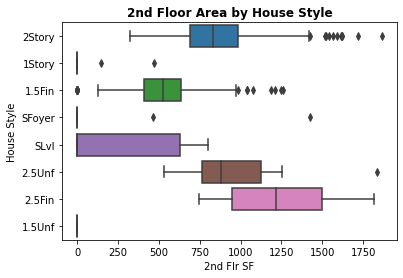

In [30]:
# Checking if 1Storey has raws with 2nd Flr SF > 0
sns.boxplot(x = '2nd Flr SF', y='House Style', data=data)
plt.title('2nd Floor Area by House Style', fontweight='bold')

In [31]:
data[(data['House Style'] == '1Story') & (data['2nd Flr SF'] > 0)]

,Id,PID,MS SubClass,MS Zoning,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Garage Yr Blt_Imputed,Lot Frontage_Imputed
513,2006,903201090,40,RL,6854,Pave,NA,Reg,Bnk,AllPub,...,NA,NA,NA,0,8,2007,WD,136500,1969.0,55.0
782,2000,902401030,40,RM,5400,Pave,Pave,Reg,Lvl,AllPub,...,NA,NA,NA,0,10,2007,WD,152000,1926.0,40.0


In [32]:
# Impute 2nd Flr SF as 0 for rows where house stype is 1story but 2nd flr SF is not 0
# Assume that House Style is correct
data.loc[(data['House Style'] == '1Story') & (data['2nd Flr SF'] > 0), '2nd Flr SF'] = 0

#### Checking Mas Vnr Area

Text(0.5, 1.0, 'Mas Vnr Area by Mas Vnr Type')

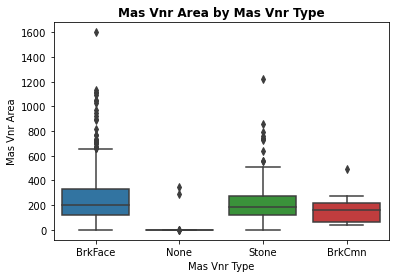

In [33]:
sns.boxplot(x='Mas Vnr Type', y = 'Mas Vnr Area', data=data)
plt.title('Mas Vnr Area by Mas Vnr Type', fontweight='bold')

- 'None' has some data points that is not 0

In [34]:
# Set Mas Vnr Area to 0 for rows where 'Mas Vnr Type' is None 
data.loc[(data['Mas Vnr Type']=='None') & (data['Mas Vnr Area']>0), 'Mas Vnr Area'] = 0

Text(0.5, 1.0, 'Mas Vnr Area by Mas Vnr Type')

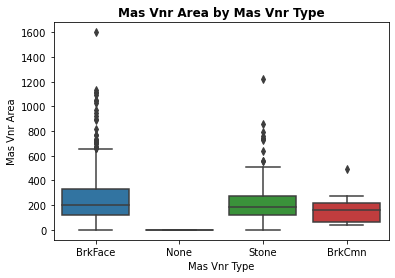

In [35]:
# Double Check
sns.boxplot(x='Mas Vnr Type', y = 'Mas Vnr Area', data=data)
plt.title('Mas Vnr Area by Mas Vnr Type', fontweight='bold')